
# Capstone Project

## Title: Using Deep Local Features to differentiate between images of very similar products
## Part 3

# Open innovation Week

# Image matching and Classification using Bonding Quotient (TM)

**Here I have explored a different approach to image matching thru computation of their similarity. Bonding Quotient(TM) is a novel similarity measure that helps discover latent pattern in the data. Have tried it out on structured data such as song listening count (Million Songs Dataset), movie rating (Netflix, Movielens 22M), word frequency of text data etc. I am trying it out on image data for the first time and it turns out that it outperforms ORB, Censure-Brief-RANSAC and Superpoint-RANSAC algorithms on triplet image set by a fair margin as shown below.**

**Datasets tried out are:**
1. **`inSitu images`** in 120 classes - most images had no or very few keypoints making comparison difficult. BQ has no such issues.
2. **`100 triplet image dataset`** generated by Project team 
3. **`20150320_DM4VM_dataset`** images in 10 classes

# Overall Intuition of Bonding Quotient and Results obtained
Each RGB image is represented as 256 * 3 = 768 dimensional vector in terms of frequency distribution of each pixel in the range 0-255. Color images are preferred as it provides 3X more information than B&W. It is then normalized with the size of the image making all images comparable like for like. In a sense RGB value of each pixel is treated as visual alphabet and its frequency distribution provides similar representational value as word frequency does for a document. In both instances, `bag of words` is used not their relative locational properties. But even without using the latter, it often does good job of classification. 

We will explore similar bag of words representation for image pixels. On top of this base feature engineering, a series of 4 transforms are applied on these features to compute a novel similarity measure called **`Bonding Quotient`**. It extracts latent thematic pattern within the training dataset, and if it is sufficiently large, provides useful `top-K nearest neighbors` of each of the test data from among the training data for which the labels are known. With `0.5 as threshold, prediction is label of the majority`.

The intuition of classification using Bonding Quotient is this: if an unknown item is most similar to known items of class A, it must be another specimen of class A. It certainly has an accuracy ceiling and dependent on a large training data capturing wide ranging representations of different classes.

Prediction accuracy on the held out datasets are Summarized below:

### `inSitu Images`: `0.89` based on 10000+ training and ~1100 validation images across 120 classes. It is like using a large base of real world images as master provided by users. As long as query images are of similar quality, Bonding Quotient can do decent classification.
### `Triplet Images`: `0.82` based on 101 unique triplets where sim1-sim2 similarity were higher than that of diff-sim1 or diff-sim2. This was far higher than 3 algorithms - ORB (`0.55`), CENSURE-BRIEF-RANSAC (`0.61`) and Superpoint-RANSAC (`0.67`) - shown in Capstone Report part 1 
### `20150320_DM4VM_dataset`: `0.47` based on 647 training and 300 validation images across 10 classes. This is low possibly because of small training dataset.

## 1. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import skimage
from skimage.io import imread_collection

import glob

# A. inSitu Images

## Read images from folders as collection

### First a few helpful functions

In [2]:
def RD_maker(ImageFileNames):
    """
    Input:   Training Image filenames from each of the image class folders where each image is an RGB
    Process: 3 stage transform - histogram, normalization, centering for each of RGB channels
    Output:  3*256 = 768 dimensional feature vector for each of the images stacked as columns
    """
    img_rd = np.zeros((768,len(ImageFileNames)))
    col_master = imread_collection(ImageFileNames)
    for i in range(len(ImageFileNames)):
        img = col_master[i]
        if len(img.shape) > 2:
            hist1, bin_edges = np.histogram(img[:,:,0].reshape([-1,1]), bins = range(257))
            hist1 = hist1/hist1.sum()
            hist2, bin_edges = np.histogram(img[:,:,1].reshape([-1,1]), bins = range(257))
            hist2 = hist2/hist2.sum()
            hist3, bin_edges = np.histogram(img[:,:,2].reshape([-1,1]), bins = range(257))
            hist3 = hist3/hist3.sum()
            img_feature = np.hstack((hist1,hist2,hist3))
            img_rd[:,i] = img_feature
        else:
            hist1, bin_edges = np.histogram(img.reshape([-1,1]), bins = range(257))
            hist1 = hist1/hist1.sum()
            hist2 = np.zeros((256))
            hist3 = np.zeros((256))
            img_feature = np.hstack((hist1,hist2,hist3))
            img_rd[:,i] = img_feature
    
    return img_rd

In [3]:
def image_feature_maker(img):
    """
    Input: Color image np-array of the shape height x width x 3. Can handle B&W but with rest being RGB, it is like comparing
    apples and oranges. Dropped inVitro because of this mixed up dataset.
    Process: 3 stage transform - histogram, normalization, centering for each of RGB
    Output: 3*256 = 768 dimensional feature vector
    """
    if len(img.shape) > 2:
        hist1, bin_edges = np.histogram(img[:,:,0].reshape([-1,1]), bins = range(257))
        hist1 = hist1/hist1.sum()
        hist2, bin_edges = np.histogram(img[:,:,1].reshape([-1,1]), bins = range(257))
        hist2 = hist2/hist2.sum()
        hist3, bin_edges = np.histogram(img[:,:,2].reshape([-1,1]), bins = range(257))
        hist3 = hist3/hist3.sum()
        img_feature = np.hstack((hist1,hist2,hist3))
    else:
        hist1, bin_edges = np.histogram(img.reshape([-1,1]), bins = range(257))
        hist1 = hist1/hist1.sum()
        hist2 = np.zeros((256))
        hist3 = np.zeros((256))
        img_feature = np.hstack((hist1,hist2,hist3))
        
    return img_feature

### Initialization for matching inSitu image files

In [4]:
RD_train = np.zeros((768,1))       # Initializer for 768 x N training data RD
trainImageClassIndex = []          # Class index of all N training images from across 120 class folders
val_ImageFileList = []             # List of image file names for validation from across 120 class folders
validation_split = .1
shuffle_dataset = True
random_seed= 42

### Create train RD, train image class and val image file list by running thru the inSitu folders

In [5]:
for i in range(120):
    imageFileNames = glob.glob('./data/inSitu/' + str(i+1) + '/video/*.PNG')
    # Creating data indices for training and validation splits:
    dataset_size = len(imageFileNames)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    train_ImageFileNames = [imageFileNames[i] for i in train_indices]       # List of image file names for training across 120
    val_ImageFileNames = [imageFileNames[i] for i in val_indices]           # List of image file names for validation across 120
    
    folderTrainRD = RD_maker(train_ImageFileNames)
    RD_train = np.concatenate((RD_train, folderTrainRD), axis=1)            # 768 x 9000+ RD matrix - 1st column to be removed

    trainImageClassIndex.append(np.ones(len(train_ImageFileNames))*(i+1)) # Training image class index for 9000 
    val_ImageFileList.extend(val_ImageFileNames)                            # List of image files for use for validation

RD_train = RD_train[:,1:]                                                   # Shape initializer Column from RD_train being removed

In [6]:
print(' Shape of training raw data file: ', RD_train.shape, '\n',
      'Number of images set aside for validation: ', len(val_ImageFileList), '\n',
      'An example validation image file name: ', val_ImageFileList[15])

 Shape of training raw data file:  (768, 10127) 
 Number of images set aside for validation:  1062 
 An example validation image file name:  ./data/inSitu/5/video\video8.png


### Transform 1 on RD file. Here converted to a 5-point scale where class intervals are based on the data distribution

In [7]:
# len(RD_train.reshape([-1,1])) - (RD_train.reshape([-1,1]) == 0).sum()
RD_train[RD_train < 0.00001] = 1
RD_train[RD_train < 0.00127] = 2
RD_train[RD_train < 0.00378] = 3
RD_train[RD_train < 0.00732] = 5
RD_train[RD_train < 0.45006] = 7

### Transform 2 using suitable weight to compute Bond Quotient among Training inSitu images. These weights are also computed based on the specific training data distribution.

In [8]:
wt = [1.00,0.66,0.32,0.16,0.06]
BQRS = np.zeros((RD_train.shape[1], RD_train.shape[1]))           # Bonding Quotient Raw Score (BQRS)
for i in range(RD_train.shape[1]):
    a = np.multiply(RD_train[:,i].reshape([768,-1]),RD_train[:,i:])
    a[a==1] = wt[0]; a[a==4] = wt[0]; a[a==9] = wt[0]; a[a==25] = wt[0]; a[a== 49] = wt[0]
    a[a==2] = wt[1]; a[a==6] = wt[1]; a[a==15] = wt[1]; a[a==35] = wt[1]
    a[a==3] = wt[2]; a[a==10] = wt[2]; a[a==21] = wt[2]
    a[a==5] = wt[3]; a[a==14] = wt[3]
    a[a==7] = wt[4]    
    
    BQRS[i,i:] = a.sum(axis=0)
    BQRS[i:,i] = a.sum(axis=0)

### Constructing RD_TEST by back-ending test image after Training RD dataset - inSitu images

In [9]:
# Flattening the training image class index
trainImageClassIndex_flat = [item for sublist in trainImageClassIndex  for item in sublist]

### Transform 3 and 4 are applied to compute Final Bonding Quotient between validation images and training images for which the classes are known.

In [10]:
output_list = []
for i in range(len(val_ImageFileList)):
    val_image_name = val_ImageFileList[i]                         # pick up val image no i out of some 2300
    val_image_name = val_image_name.split('\\')                   # Remove \\ from glob list
    val_image_name = val_image_name[0] + '/' + val_image_name[1]  # Add / to join 1st part with 2nd part of val image filename
    val_image_name_class = int(val_image_name.split('/')[3])      # Note the class label of the val image
    img = skimage.io.imread(val_image_name)
    
    test_feature = image_feature_maker(img).reshape([-1,1])
    test_feature[test_feature < 0.00001] = 1
    test_feature[test_feature < 0.00127] = 2
    test_feature[test_feature < 0.00378] = 3
    test_feature[test_feature < 0.00732] = 5
    test_feature[test_feature < 0.45006] = 7

    RD_TEST = np.concatenate((RD_train, test_feature), axis=1)
    
    BQRS_test = np.zeros((RD_train.shape[1]+1, RD_train.shape[1]+1))
    a = np.multiply(RD_TEST[:,-1].reshape([768,-1]),RD_TEST)
    a[a==1] = wt[0]; a[a==4] = wt[0]; a[a==9] = wt[0]; a[a==25] = wt[0]; a[a== 49] = wt[0]
    a[a==2] = wt[1]; a[a==6] = wt[1]; a[a==15] = wt[1]; a[a==35] = wt[1]
    a[a==3] = wt[2]; a[a==10] = wt[2]; a[a==21] = wt[2]
    a[a==5] = wt[3]; a[a==14] = wt[3]
    a[a==7] = wt[4]
        
    BQRS_test[-1,0:] = a.sum(axis=0)
    BQRS_test[0:,-1] = a.sum(axis=0)
    BQRS_test[:RD_train.shape[1],:RD_train.shape[1]] = BQRS
    BQNS_test = BQRS_test/np.diagonal(BQRS_test)                     # Bonding Quotient Normalized Score
    BQCorr1_test = np.corrcoef(BQNS_test.T)                          # Bonding Quotient Correlation Level 1
    predicts_class_top10 = np.array(trainImageClassIndex_flat)[BQCorr1_test[-1].argsort()[-11:][::-1][1:]]
    correct_class_prediction = ((predicts_class_top10 == int(val_image_name_class)) == True).sum()
    if correct_class_prediction > 4:
        accuracy = 1
    else:
        accuracy = 0            
    
    output_list.append([i, val_image_name, val_image_name_class, correct_class_prediction, accuracy])
    print(i, val_image_name, val_image_name_class, correct_class_prediction, accuracy)

0 ./data/inSitu/1/video/video5.png 1 9 1
1 ./data/inSitu/1/video/video25.png 1 10 1
2 ./data/inSitu/1/video/video34.png 1 10 1
3 ./data/inSitu/2/video/video17.png 2 8 1
4 ./data/inSitu/2/video/video24.png 2 3 0
5 ./data/inSitu/3/video/video37.png 3 10 1
6 ./data/inSitu/3/video/video1.png 3 10 1
7 ./data/inSitu/3/video/video3.png 3 10 1
8 ./data/inSitu/3/video/video38.png 3 5 1
9 ./data/inSitu/3/video/video26.png 3 2 0
10 ./data/inSitu/3/video/video35.png 3 10 1
11 ./data/inSitu/3/video/video19.png 3 7 1
12 ./data/inSitu/3/video/video58.png 3 5 1
13 ./data/inSitu/4/video/video23.png 4 2 0
14 ./data/inSitu/4/video/video18.png 4 10 1
15 ./data/inSitu/5/video/video8.png 5 10 1
16 ./data/inSitu/5/video/video61.png 5 10 1
17 ./data/inSitu/5/video/video1.png 5 10 1
18 ./data/inSitu/5/video/video49.png 5 10 1
19 ./data/inSitu/5/video/video14.png 5 10 1
20 ./data/inSitu/5/video/video42.png 5 10 1
21 ./data/inSitu/6/video/video94.png 6 10 1
22 ./data/inSitu/6/video/video12.png 6 10 1
23 ./data/i

180 ./data/inSitu/21/video/video156.png 21 10 1
181 ./data/inSitu/21/video/video183.png 21 10 1
182 ./data/inSitu/21/video/video43.png 21 10 1
183 ./data/inSitu/21/video/video84.png 21 10 1
184 ./data/inSitu/21/video/video169.png 21 10 1
185 ./data/inSitu/21/video/video160.png 21 10 1
186 ./data/inSitu/21/video/video494.png 21 10 1
187 ./data/inSitu/21/video/video168.png 21 10 1
188 ./data/inSitu/21/video/video225.png 21 10 1
189 ./data/inSitu/21/video/video100.png 21 10 1
190 ./data/inSitu/21/video/video88.png 21 10 1
191 ./data/inSitu/21/video/video170.png 21 10 1
192 ./data/inSitu/21/video/video287.png 21 10 1
193 ./data/inSitu/21/video/video263.png 21 10 1
194 ./data/inSitu/21/video/video7.png 21 10 1
195 ./data/inSitu/21/video/video380.png 21 10 1
196 ./data/inSitu/21/video/video275.png 21 10 1
197 ./data/inSitu/21/video/video98.png 21 10 1
198 ./data/inSitu/21/video/video129.png 21 10 1
199 ./data/inSitu/21/video/video382.png 21 10 1
200 ./data/inSitu/21/video/video1.png 21 10 1


354 ./data/inSitu/37/video/video238.png 37 10 1
355 ./data/inSitu/37/video/video254.png 37 10 1
356 ./data/inSitu/38/video/video27.png 38 2 0
357 ./data/inSitu/38/video/video54.png 38 2 0
358 ./data/inSitu/38/video/video53.png 38 3 0
359 ./data/inSitu/38/video/video20.png 38 10 1
360 ./data/inSitu/38/video/video5.png 38 3 0
361 ./data/inSitu/39/video/video25.png 39 10 1
362 ./data/inSitu/39/video/video21.png 39 5 1
363 ./data/inSitu/39/video/video13.png 39 8 1
364 ./data/inSitu/40/video/video1.png 40 4 0
365 ./data/inSitu/40/video/video14.png 40 10 1
366 ./data/inSitu/40/video/video51.png 40 10 1
367 ./data/inSitu/40/video/video38.png 40 10 1
368 ./data/inSitu/40/video/video21.png 40 10 1
369 ./data/inSitu/40/video/video6.png 40 10 1
370 ./data/inSitu/41/video/video5.png 41 7 1
371 ./data/inSitu/42/video/video43.png 42 5 1
372 ./data/inSitu/42/video/video31.png 42 3 0
373 ./data/inSitu/42/video/video32.png 42 3 0
374 ./data/inSitu/42/video/video42.png 42 8 1
375 ./data/inSitu/43/video/

529 ./data/inSitu/57/video/video46.png 57 10 1
530 ./data/inSitu/57/video/video33.png 57 0 0
531 ./data/inSitu/57/video/video5.png 57 10 1
532 ./data/inSitu/58/video/video4.png 58 5 1
533 ./data/inSitu/59/video/video32.png 59 8 1
534 ./data/inSitu/59/video/video19.png 59 8 1
535 ./data/inSitu/59/video/video116.png 59 7 1
536 ./data/inSitu/59/video/video127.png 59 10 1
537 ./data/inSitu/59/video/video86.png 59 10 1
538 ./data/inSitu/59/video/video33.png 59 7 1
539 ./data/inSitu/59/video/video45.png 59 8 1
540 ./data/inSitu/59/video/video78.png 59 10 1
541 ./data/inSitu/59/video/video56.png 59 10 1
542 ./data/inSitu/59/video/video122.png 59 10 1
543 ./data/inSitu/59/video/video69.png 59 9 1
544 ./data/inSitu/59/video/video123.png 59 10 1
545 ./data/inSitu/60/video/video21.png 60 4 0
546 ./data/inSitu/60/video/video45.png 60 6 1
547 ./data/inSitu/60/video/video37.png 60 10 1
548 ./data/inSitu/60/video/video50.png 60 1 0
549 ./data/inSitu/60/video/video25.png 60 6 1
550 ./data/inSitu/61/vi

704 ./data/inSitu/76/video/video156.png 76 10 1
705 ./data/inSitu/76/video/video272.png 76 10 1
706 ./data/inSitu/76/video/video158.png 76 9 1
707 ./data/inSitu/76/video/video740.png 76 10 1
708 ./data/inSitu/76/video/video752.png 76 10 1
709 ./data/inSitu/76/video/video222.png 76 10 1
710 ./data/inSitu/76/video/video530.png 76 10 1
711 ./data/inSitu/76/video/video29.png 76 9 1
712 ./data/inSitu/76/video/video578.png 76 10 1
713 ./data/inSitu/76/video/video84.png 76 10 1
714 ./data/inSitu/76/video/video458.png 76 10 1
715 ./data/inSitu/76/video/video614.png 76 10 1
716 ./data/inSitu/76/video/video716.png 76 10 1
717 ./data/inSitu/76/video/video47.png 76 10 1
718 ./data/inSitu/76/video/video633.png 76 9 1
719 ./data/inSitu/76/video/video707.png 76 10 1
720 ./data/inSitu/76/video/video612.png 76 10 1
721 ./data/inSitu/76/video/video481.png 76 10 1
722 ./data/inSitu/76/video/video666.png 76 10 1
723 ./data/inSitu/76/video/video177.png 76 10 1
724 ./data/inSitu/76/video/video623.png 76 10 

879 ./data/inSitu/96/video/video4.png 96 10 1
880 ./data/inSitu/96/video/video7.png 96 10 1
881 ./data/inSitu/96/video/video13.png 96 10 1
882 ./data/inSitu/97/video/video4.png 97 9 1
883 ./data/inSitu/97/video/video7.png 97 9 1
884 ./data/inSitu/97/video/video13.png 97 10 1
885 ./data/inSitu/98/video/video17.png 98 10 1
886 ./data/inSitu/98/video/video24.png 98 2 0
887 ./data/inSitu/99/video/video1.png 99 2 0
888 ./data/inSitu/100/video/video66.png 100 6 1
889 ./data/inSitu/100/video/video46.png 100 9 1
890 ./data/inSitu/100/video/video94.png 100 9 1
891 ./data/inSitu/100/video/video26.png 100 10 1
892 ./data/inSitu/100/video/video83.png 100 10 1
893 ./data/inSitu/100/video/video85.png 100 10 1
894 ./data/inSitu/100/video/video68.png 100 10 1
895 ./data/inSitu/100/video/video48.png 100 10 1
896 ./data/inSitu/100/video/video19.png 100 10 1
897 ./data/inSitu/101/video/video1.png 101 0 0
898 ./data/inSitu/101/video/video14.png 101 10 1
899 ./data/inSitu/101/video/video51.png 101 10 1
900

1047 ./data/inSitu/118/video/video60.png 118 10 1
1048 ./data/inSitu/118/video/video1.png 118 4 0
1049 ./data/inSitu/118/video/video61.png 118 10 1
1050 ./data/inSitu/118/video/video14.png 118 8 1
1051 ./data/inSitu/118/video/video53.png 118 10 1
1052 ./data/inSitu/119/video/video23.png 119 0 0
1053 ./data/inSitu/119/video/video18.png 119 5 1
1054 ./data/inSitu/120/video/video37.png 120 10 1
1055 ./data/inSitu/120/video/video1.png 120 10 1
1056 ./data/inSitu/120/video/video3.png 120 10 1
1057 ./data/inSitu/120/video/video38.png 120 10 1
1058 ./data/inSitu/120/video/video26.png 120 10 1
1059 ./data/inSitu/120/video/video35.png 120 10 1
1060 ./data/inSitu/120/video/video19.png 120 10 1
1061 ./data/inSitu/120/video/video58.png 120 0 0


# Accuracy of Prediction for Validation dataset for inSitu images

In [11]:
print(' Prediction Accuracy at a class level for inSitu Images: ', sum([output_list[i][4] for i in range(len(output_list))])/len(output_list), '\n',
      'Prediction Accuracy at image level for inSitu Images:', sum([output_list[i][3] for i in range(len(output_list))])/(10*len(output_list)))

 Prediction Accuracy at a class level for inSitu Images:  0.8954802259887006 
 Prediction Accuracy at image level for inSitu Images: 0.8518832391713748


# B. Triplet Images

### Initialization

In [12]:
RD = np.zeros((768,1))       # Initializer for 768 x 9000 odd training data RD

### Create train RD to compute Bonding Quotient between triplet images

In [13]:
all_images = []
ImageClassIndex = []
for i in range(101):
    tripletImages = glob.glob('temp/superdataset/' + str(i+1) + '/*.jpg')
    all_images.extend(tripletImages)
    # Creating data indices for training and validation splits:
    
    folderTrainRD = RD_maker(tripletImages)
    RD = np.concatenate((RD, folderTrainRD), axis=1)            # 768 x N RD matrix - 1st column to be removed

    ImageClassIndex.append(np.ones(len(tripletImages))*(i+1)) # Training image class index for N

RD = RD[:,1:]                                                   # Shape initializer Column from RD_train being removed

In [14]:
print(' Shape of training raw data file: ', RD.shape)
# ImageClassIndex

 Shape of training raw data file:  (768, 303)


**Random image samples**

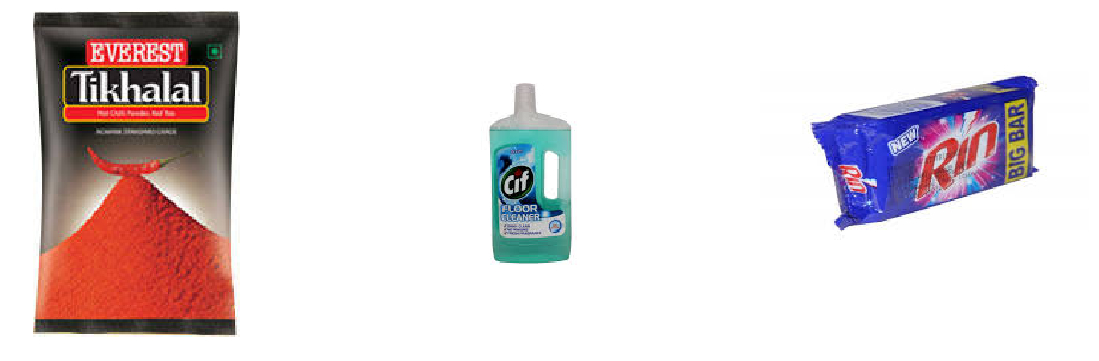

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
i = np.random.randint(1,303)
j = np.random.randint(1,303)
k = np.random.randint(1,303)

img1 = skimage.io.imread(all_images[i])
img2 = skimage.io.imread(all_images[j])
img3 = skimage.io.imread(all_images[k])

ax[0].imshow(img1)
ax[0].axis('off')

ax[1].imshow(img2)
ax[1].axis('off')

ax[2].imshow(img3)
ax[2].axis('off')

plt.show()

In [16]:
# len(RD_train.reshape([-1,1])) - (RD_train.reshape([-1,1]) == 0).sum()
RD[RD < 0.00039] = 1
RD[RD < 0.00088] = 2
RD[RD < 0.00166] = 3
RD[RD < 0.00340] = 5
RD[RD < 0.85840] = 7

In [33]:
# Flatten ImageClassIndex_flat
ImageClassIndex_flat = [item for sublist in ImageClassIndex  for item in sublist]

### Constructing Bonding Quotient Raw Score (BQRS) on Training Raw Data (RD)

In [18]:
wt = [1.00,0.65,0.31,0.15,0.08]
BQRS_triplet = np.zeros((RD.shape[1], RD.shape[1]))
for i in range(RD.shape[1]):
    a = np.multiply(RD[:,i].reshape([768,-1]),RD[:,i:])
    a[a==1] = wt[0]; a[a==4] = wt[0]; a[a==9] = wt[0]; a[a==25] = wt[0]; a[a== 49] = wt[0]
    a[a==2] = wt[1]; a[a==6] = wt[1]; a[a==15] = wt[1]; a[a==35] = wt[1]
    a[a==3] = wt[2]; a[a==10] = wt[2]; a[a==21] = wt[2]
    a[a==5] = wt[3]; a[a==14] = wt[3]
    a[a==7] = wt[4]    
    
    BQRS_triplet[i,i:] = a.sum(axis=0)
    BQRS_triplet[i:,i] = a.sum(axis=0)

In [19]:
BQNS_triplet = BQRS_triplet/np.diagonal(BQRS_triplet)
BQCorr1_triplet = np.corrcoef(BQNS_triplet.T)

In [20]:
ind = np.arange(0, RD.shape[1],3)

In [21]:
accuracy = 0
avg_sim1_diff = []
avg_sim2_diff = []
avg_sim1_sim2 = []
for i in range(len(ind)):
    comp = BQCorr1_triplet[ind[i]:ind[i]+3,ind[i]:ind[i]+3]
    avg_sim1_diff.append(comp[0,1])
    avg_sim2_diff.append(comp[0,2])
    avg_sim1_sim2.append(comp[1,2])
    if (comp[1,2] > comp[0,1]) or (comp[1,2] > comp[0,2]):
        accuracy += 1
    else:
        accuracy += 0

print('Avg Sim betn. diff shots of same product using Bonding Quotient: ',round(np.mean(avg_sim1_sim2),2))
print('Avg Sim betn. 2 slightly different products (sim1 vs diff) using Bonding Quotient: ', round(np.mean(avg_sim1_diff),2))
print('Avg Sim betn. 2 slightly different products (sim2 vs diff) using Bonding Quotient: ', round(np.mean(avg_sim2_diff),2))
print('Overall class prediction Accuracy using Bonding Quotient: ', round(accuracy/len(ind),2))

Avg Sim betn. diff shots of same product using Bonding Quotient:  0.67
Avg Sim betn. 2 slightly different products (sim1 vs diff) using Bonding Quotient:  0.48
Avg Sim betn. 2 slightly different products (sim2 vs diff) using Bonding Quotient:  0.48
Overall class prediction Accuracy using Bonding Quptient:  0.82


# C. 20150320_DM4VM_dataset Images

## Read images from folders as collection to

In [22]:
folders = glob.glob('./data/20150320_DM4VM_dataset/*')

train_ImageFolders = []
val_ImageFolders = []

for folder in folders:
    folder.split('\\')[0] + '/' + folder.split('\\')[1] + '/train/'
    train_ImageFolders.append(folder.split('\\')[0] + '/' + folder.split('\\')[1] + '/train/')
    val_ImageFolders.append(folder.split('\\')[0] + '/' + folder.split('\\')[1] + '/test/')

### Initialization for matching 20150320_DM4VM_dataset image files

In [23]:
RD_train = np.zeros((768,1))       # Initializer for 768 x 9000 odd training data RD
trainImageClassIndex = []          # Class index of all 9000 odd training images from across 120 class folders
val_ImageFileList = []             # List of image file names for validation from across 120 class folders

In [24]:
folder_nos = [(glob.glob(train_ImageFolders[i] + '*.jpg')[0].split('\\')[0] + '/' + glob.glob(train_ImageFolders[i] + '*.jpg')[i].split('\\')[1]).split('/')[3] for i in range(len(train_ImageFolders))]
folder_nos = [int(folder_nos[i]) for i in range(len(folder_nos))]
print(folder_nos)

[1, 105, 116, 12, 140, 23, 32, 47, 59, 70]


### Create train and val RD, train image class and val image file list by running thru the 20150320_DM4VM_dataset

In [25]:
for i in range(len(train_ImageFolders)):
    train_ImageFileNames = []
    val_ImageFileNames = []
    train_rough = glob.glob(train_ImageFolders[i] + '*.jpg')
    val_rough = glob.glob(val_ImageFolders[i] + '*.jpg')
    for j in range(len(train_rough)):
        train_ImageFileNames.append(train_rough[j].split('\\')[0] + '/' + train_rough[0].split('\\')[1])
    for j in range(len(val_rough)):
        val_ImageFileNames.append(val_rough[j].split('\\')[0] + '/' + val_rough[j].split('\\')[1])
    
    folderTrainRD = RD_maker(train_ImageFileNames)
    RD_train = np.concatenate((RD_train, folderTrainRD), axis=1)            # 768 x N RD matrix - 1st column to be removed

    trainImageClassIndex.append(np.ones(len(train_ImageFileNames))*(folder_nos[i])) # Training image class index for 9000 
    val_ImageFileList.extend(val_ImageFileNames)                            # List of image files for use for validation

RD_train = RD_train[:,1:]                                                   # Shape initializer Column from RD_train being removed

In [26]:
# trainImageClassIndex
RD_train.shape, len([item for sublist in trainImageClassIndex  for item in sublist]), len(val_ImageFileList)
# val_ImageFileList

((768, 647), 647, 300)

In [27]:
print(' Shape of training raw data file: ', RD_train.shape, '\n',
      'Number of images set aside for validation: ', len(val_ImageFileList), '\n',
      'An example validation image file name: ', val_ImageFileList[15])

 Shape of training raw data file:  (768, 647) 
 Number of images set aside for validation:  300 
 An example validation image file name:  ./data/20150320_DM4VM_dataset/1/test/set57_14_s4_305.jpg


In [28]:
RD_train[RD_train < 0.00069] = 1
RD_train[RD_train < 0.00196] = 2
RD_train[RD_train < 0.00322] = 3
RD_train[RD_train < 0.00612] = 5
RD_train[RD_train < 0.04313] = 7

### Constructing Training RD BQRS for 20150320_DM4VM_dataset images

In [29]:
wt = [1.00,0.66,0.32,0.16,0.06]
BQRS = np.zeros((RD_train.shape[1], RD_train.shape[1]))
for i in range(RD_train.shape[1]):
    a = np.multiply(RD_train[:,i].reshape([768,-1]),RD_train[:,i:])
    a[a==1] = wt[0]; a[a==4] = wt[0]; a[a==9] = wt[0]; a[a==25] = wt[0]; a[a== 49] = wt[0]
    a[a==2] = wt[1]; a[a==6] = wt[1]; a[a==15] = wt[1]; a[a==35] = wt[1]
    a[a==3] = wt[2]; a[a==10] = wt[2]; a[a==21] = wt[2]
    a[a==5] = wt[3]; a[a==14] = wt[3]
    a[a==7] = wt[4]    
    
    BQRS[i,i:] = a.sum(axis=0)
    BQRS[i:,i] = a.sum(axis=0)

### Constructing RD_TEST by back-ending test image after Training RD dataset - 20150320_DM4VM_dataset

In [30]:
trainImageClassIndex_flat = [item for sublist in trainImageClassIndex  for item in sublist]

In [31]:
output_list = []
for i in range(len(val_ImageFileList)):
    val_image_name = val_ImageFileList[i]                         # pick up val image no i out of some 2300
    val_image_name_class = int(val_image_name.split('/')[3])      # Note the class label of the val image
    img = skimage.io.imread(val_image_name)
    
    test_feature = image_feature_maker(img).reshape([-1,1])
    test_feature[test_feature < 0.00069] = 1
    test_feature[test_feature < 0.00196] = 2
    test_feature[test_feature < 0.00322] = 3
    test_feature[test_feature < 0.00612] = 5
    test_feature[test_feature < 0.04313] = 7
    
    RD_TEST = np.concatenate((RD_train, test_feature), axis=1)
    
    BQRS_test = np.zeros((RD_train.shape[1]+1, RD_train.shape[1]+1))
    a = np.multiply(RD_TEST[:,-1].reshape([768,-1]),RD_TEST)
    a[a==1] = wt[0]; a[a==4] = wt[0]; a[a==9] = wt[0]; a[a==25] = wt[0]; a[a== 49] = wt[0]
    a[a==2] = wt[1]; a[a==6] = wt[1]; a[a==15] = wt[1]; a[a==35] = wt[1]
    a[a==3] = wt[2]; a[a==10] = wt[2]; a[a==21] = wt[2]
    a[a==5] = wt[3]; a[a==14] = wt[3]
    a[a==7] = wt[4]
        
    BQRS_test[-1,0:] = a.sum(axis=0)
    BQRS_test[0:,-1] = a.sum(axis=0)
    BQRS_test[:647,:647] = BQRS
    BQNS_test = BQRS_test/np.diagonal(BQRS_test)
    BQCorr1_test = np.corrcoef(BQNS_test.T)
    predicts_class_top10 = np.array(trainImageClassIndex_flat)[BQCorr1_test[-1].argsort()[-11:][::-1][1:]]
    correct_class_prediction = ((predicts_class_top10 == int(val_image_name_class)) == True).sum()
    if correct_class_prediction > 4:
        accuracy = 1
    else:
        accuracy = 0            
    
    output_list.append([i, val_image_name, val_image_name_class, correct_class_prediction, accuracy])
    print(i, val_image_name, val_image_name_class, correct_class_prediction, accuracy)

0 ./data/20150320_DM4VM_dataset/1/test/set110_1_s2_15.jpg 1 0 0
1 ./data/20150320_DM4VM_dataset/1/test/set110_1_s2_17.jpg 1 10 1
2 ./data/20150320_DM4VM_dataset/1/test/set110_1_s2_19.jpg 1 10 1
3 ./data/20150320_DM4VM_dataset/1/test/set110_1_s2_22.jpg 1 10 1
4 ./data/20150320_DM4VM_dataset/1/test/set110_1_s3_28.jpg 1 10 1
5 ./data/20150320_DM4VM_dataset/1/test/set110_1_s3_29.jpg 1 10 1
6 ./data/20150320_DM4VM_dataset/1/test/set117_3_s4_80.jpg 1 0 0
7 ./data/20150320_DM4VM_dataset/1/test/set119_1_s4_59.jpg 1 0 0
8 ./data/20150320_DM4VM_dataset/1/test/set139_2_s5_41.jpg 1 0 0
9 ./data/20150320_DM4VM_dataset/1/test/set19_1_s2_6.jpg 1 0 0
10 ./data/20150320_DM4VM_dataset/1/test/set29_3_s4_125.jpg 1 0 0
11 ./data/20150320_DM4VM_dataset/1/test/set44_7_s4_221.jpg 1 0 0
12 ./data/20150320_DM4VM_dataset/1/test/set56_8_s6_217.jpg 1 10 1
13 ./data/20150320_DM4VM_dataset/1/test/set56_8_s6_218.jpg 1 0 0
14 ./data/20150320_DM4VM_dataset/1/test/set56_8_s6_219.jpg 1 0 0
15 ./data/20150320_DM4VM_datase

124 ./data/20150320_DM4VM_dataset/140/test/set457_4_s4_120.jpg 140 10 1
125 ./data/20150320_DM4VM_dataset/140/test/set457_4_s4_121.jpg 140 0 0
126 ./data/20150320_DM4VM_dataset/140/test/set458_1_s4_75.jpg 140 0 0
127 ./data/20150320_DM4VM_dataset/140/test/set458_1_s4_76.jpg 140 0 0
128 ./data/20150320_DM4VM_dataset/140/test/set458_1_s4_77.jpg 140 0 0
129 ./data/20150320_DM4VM_dataset/140/test/set460_8_s4_134.jpg 140 0 0
130 ./data/20150320_DM4VM_dataset/140/test/set470_2_s3_125.jpg 140 0 0
131 ./data/20150320_DM4VM_dataset/140/test/set473_1_s4_39.jpg 140 0 0
132 ./data/20150320_DM4VM_dataset/140/test/set473_1_s4_40.jpg 140 0 0
133 ./data/20150320_DM4VM_dataset/140/test/set477_4_s4_143.jpg 140 0 0
134 ./data/20150320_DM4VM_dataset/140/test/set477_5_s4_193.jpg 140 0 0
135 ./data/20150320_DM4VM_dataset/140/test/set477_5_s4_194.jpg 140 10 1
136 ./data/20150320_DM4VM_dataset/140/test/set477_5_s4_195.jpg 140 0 0
137 ./data/20150320_DM4VM_dataset/140/test/set482_9_s3_178.jpg 140 10 1
138 ./da

242 ./data/20150320_DM4VM_dataset/59/test/set629_7_s2_176.jpg 59 0 0
243 ./data/20150320_DM4VM_dataset/59/test/set643_1_s3_31.jpg 59 10 1
244 ./data/20150320_DM4VM_dataset/59/test/set644_4_s3_209.jpg 59 10 1
245 ./data/20150320_DM4VM_dataset/59/test/set655_3_s2_82.jpg 59 10 1
246 ./data/20150320_DM4VM_dataset/59/test/set655_3_s2_83.jpg 59 10 1
247 ./data/20150320_DM4VM_dataset/59/test/set696_5_s2_124.jpg 59 10 1
248 ./data/20150320_DM4VM_dataset/59/test/set722_3_s2_75.jpg 59 0 0
249 ./data/20150320_DM4VM_dataset/59/test/set722_3_s2_76.jpg 59 0 0
250 ./data/20150320_DM4VM_dataset/59/test/set752_4_s2_164.jpg 59 0 0
251 ./data/20150320_DM4VM_dataset/59/test/set752_4_s2_165.jpg 59 0 0
252 ./data/20150320_DM4VM_dataset/59/test/set758_1_s2_19.jpg 59 10 1
253 ./data/20150320_DM4VM_dataset/59/test/set764_9_s1_236.jpg 59 0 0
254 ./data/20150320_DM4VM_dataset/59/test/set781_4_s3_96.jpg 59 10 1
255 ./data/20150320_DM4VM_dataset/59/test/set781_4_s3_97.jpg 59 10 1
256 ./data/20150320_DM4VM_dataset/

# Accuracy of Prediction for Validation dataset for 20150320_DM4VM_dataset images

In [32]:
print(' Prediction Accuracy at a class level: ', sum([output_list[i][4] for i in range(len(output_list))])/len(output_list), '\n',
      'Prediction Accuracy at image level:', sum([output_list[i][3] for i in range(len(output_list))])/(10*len(output_list)))

 Prediction Accuracy at a class level:  0.47 
 Prediction Accuracy at image level: 0.47
